# Challenge 3 Patent Reconmmender System


In [45]:
# Import section
%matplotlib inline

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import math
from sklearn.model_selection import train_test_split
import gensim
# solve issue of gensim version
!pip install --upgrade gensim

Requirement already up-to-date: gensim in c:\programdata\anaconda3\lib\site-packages (4.0.1)


# UTILS


In [31]:
# function used when the FSC is a string passing it to a list, to be more easly analyzed
def validate_parse_fsc(row_fsc):
    fscList = []
    if('FSC' in row_fsc):
        fscList = row_fsc['FSC']
    
    if(not isinstance(fscList,list)):
        fscList = [fscList]
    
    return fscList

def get_model_best_match(abstract,model):
    inferred_vector = model.infer_vector(gensim.utils.simple_preprocess(abstract))
    return model.dv.most_similar([inferred_vector], topn=len(model.dv))

def get_FSC_classes_row(ID):
    best_match_classes = train_classes_data[train_classes_data['ID'] == ID]
    return best_match_classes['classes'].iloc[0]


# returns 2 DataFrames one for text mining and another one for classes
def get_scenario_data(data, domain):
    # lists for dataframe
    #_ID = []
    Resumo = []
    Titulo = []
    FSC_Classes = []
    ID = []
    for patent in data.iterrows():
        # validate if data contains one of these classes
        contained = [a in validate_parse_fsc(patent[1][2]) for a in domain]

        # add to the lists
        if True in contained:
            #k.append(patent)
            #_ID.append()
            Resumo.append(patent[1][0])
            Titulo.append(patent[1][1])
            FSC_Classes.append(patent[1][2])
            ID.append(patent[1][3])
            #print("ID: "+str(patent[1][3])+" FSC: "+ str(patent[1][2])+"\n")
            
    # create and return dataframe
    return pd.DataFrame({"ID": ID, "Resumo": Resumo , "Titulo": Titulo}), pd.DataFrame({"ID":ID, "classes":FSC_Classes})



def evaluate_classes(enableprint, top_k, df_rows,tipo,modelo):
    ID_Test = []
    ID_Match = []
    SimilarityRank = []
    FSC_Overlap = []
    Precision = []
    ID_Precision_Test = []
    
    data = test_data.head(df_rows) 
  
    for index,row in data.iterrows():
        test_Data_sample = get_model_best_match(row[tipo],modelo)
    
        # contadores para precisão
        relevant = 0
    
        for similarityRank in range(0,top_k):
            match_ID = str(modelIndexToDataframeIndex[test_Data_sample[similarityRank][0]-1])

            best_match_data = train_data[train_data['ID'] == match_ID]
            #print("best_match_data: "+ best_match_data)

            best_match_fsc_row = get_FSC_classes_row(match_ID)
            test_fsc_row = get_FSC_classes_row(row['ID'])

            fsc_list_best_match = validate_parse_fsc(best_match_fsc_row)
            fsc_test_data_row = validate_parse_fsc(test_fsc_row)

            intersection_fsc_classes = list(set(fsc_list_best_match).intersection(set(fsc_test_data_row)))
    
            if len(fsc_test_data_row) != 0:
                overlap_ratio = len(intersection_fsc_classes)/len(fsc_test_data_row)

                ID_Test.append(row['ID'])
                ID_Match.append(match_ID)
                SimilarityRank.append(similarityRank)
                FSC_Overlap.append(overlap_ratio)
        
                if intersection_fsc_classes and enableprint:
        
                    print("Test Sample ID : "+ row['ID'])
                    print("Match ID : " + match_ID)
                    print("Titulo Test Sample: "+ row['Titulo'])
                    #print("Titulo Match: "+ best_match_data.iloc[0]['Titulo'])
                   
                    print("Resumo Test Sample: "+ row['Resumo'])
                    print("Resumo Match: "+ best_match_data.iloc[0]['Resumo'])
                    print("Class Overlap" + str(intersection_fsc_classes) )
                    print("Class Overlap Ratio" + str(overlap_ratio) + '\n')

                if overlap_ratio >= 0.5:
                    relevant += 1
        #print(relevant)
        precision = relevant / top_k
        Precision.append(precision)
        ID_Precision_Test.append(row['ID'])
        #df_precision_new_row = {"ID_Test": ID_Test, "RecommendationPrecision":precision}
        #df_precision.append(df_precision_new_row, ignore_index=True)
        if enableprint:
            print("Precision" + str(precision) + '\n')
    

    return pd.DataFrame({"ID_Test":ID_Test,"ID_Match":ID_Match,"SimilarityRank":SimilarityRank,"FSC_Overlap":FSC_Overlap}), pd.DataFrame({"ID_Test":ID_Precision_Test,"Precision":Precision})


# model - modelo
# sample - input a testar
# tag - Titulo ou Resumo
def infer_similar(model, sample, tag, top):
    top -= 1
    inferred_vector = model.infer_vector(gensim.utils.simple_preprocess(sample.iloc[0][tag]))
    sims = model.dv.most_similar([inferred_vector], topn=len(model.dv))
    best_match_row = train_data[train_data['ID'] == modelIndexToDataframeIndex[sims[top][0]-1]]
    print("Similarity: "+ str(sims[top][1])) 
    print("ID: "+ best_match_row.iloc[0]['ID'])
    print("Titulo: "+ best_match_row.iloc[0]['Titulo'])
    print("Resumo: "+ best_match_row.iloc[0]['Resumo'])
    value = str(best_match_row.iloc[0]['ID'])
    fscList = train_classes_data.iloc[best_match_row.index]['classes'].iloc[0]['FSC']
    print("FSC: "+ str(fscList))


# Import Dataset

*Dataset composition*   

| Feature        | Description           |
| -------------- | --------------------- |
| ID             | The patent ID         |
| Title          | Patent Title          |
| Abstract       | Patent Abstract       |
| Classification | [Patent Classification](https://www.uspto.gov/web/patents/classification/selectnumwithtitle.htm) |

## How to export from database


```
db.10000.find(
  {'classes.FSC': {$exists: true},title: {$exists: true},'abstract': {$exists: true}},
  {'abstract': 1,title: 1,'classes.FSC': 1}
)
```


```
[{$sample: {
  size: 10000
}}, {$project: { _id: {$toString: "$_id"}, abstract : 1, title : 1, "classes.FSC" :1}}, {$match: {"classes" :{"$exists":true},title:{"$exists":true},abstract:{"$exists":true}}}]
```


In [6]:
url = 'https://raw.githubusercontent.com/DGuilherme/Challenge3/main/Dataset/10000_classified_patents.json'

data_path ='C:/Users/ricar/Downloads/dataset_Luis.json'

# Preprocessing 


In [7]:
raw_train_data = pd.read_json(data_path)
raw_train_data = raw_train_data.rename(columns={'_id': 'ID', 'abstract': 'Resumo','title': 'Titulo'})
raw_train_data = raw_train_data.dropna()
raw_train_data = raw_train_data.drop_duplicates(subset ="Resumo",keep = False)
raw_train_data = raw_train_data.drop_duplicates(subset ="Titulo",keep = False)

2021-04-25 21:54:19,366 : INFO : Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2021-04-25 21:54:19,367 : INFO : NumExpr defaulting to 8 threads.


## Scenario 1
Using a random dataset

In [8]:



# the names that are defined here must be universal for this notebook
train_classes_data = raw_train_data[['ID','classes']]
train_data_unsplit = raw_train_data[['ID','Titulo','Resumo']]

# Split dataset
train_data, test_data = train_test_split(train_data_unsplit, test_size=0.2)

## Scenario 2
In this scenario we use patents from the same domain, Industry

In [9]:
# method to get data for industry domain
industry_domain = ['028','065','072','073','075','076','081','082','083','095','096','110','164','187','264','266','336','373','438','445','493','505','714','715']


#pd.DataFrame({"ID_Test":ID_Test,"ID_Match":ID_Match,"SimilarityRank":SimilarityRank,"FSC_Overlap":FSC_Overlap}), pd.DataFrame({"ID_Test":ID_Precision_Test,"Precision":Prec
industry_patents_df, industry_patents_classes_df = get_scenario_data(raw_train_data, industry_domain)

**Only run thes following cell to if it is to change the the scenario 2 data**

In [10]:
# Split dataset

train_data, test_data = train_test_split(industry_patents_df, test_size=0.2)
train_classes_data = industry_patents_classes_df

# Create the Vocabulary

In [11]:
modelIndexToDataframeIndex = []



def tagData(dataframe,tag):
    number = 0
    for index,row in dataframe.iterrows():
        number = number + 1
        modelIndexToDataframeIndex.append(row['ID'])
        resumotokens = gensim.utils.simple_preprocess(row[tag])

        yield gensim.models.doc2vec.TaggedDocument(resumotokens, [number])

vocabulary_resumo = list(tagData(train_data,'Resumo'))
vocabulary_test_resumo = list(tagData(test_data,'Resumo'))

vocabulary_titulo = list(tagData(train_data,'Titulo'))
vocabulary_test_titulo = list(tagData(test_data,'Titulo'))

C:\ProgramData\Anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


# Create gensim Doc2Vec model

In [12]:
# instanciate
model_resumo = gensim.models.doc2vec.Doc2Vec(vector_size=100, min_count=2, epochs=100) # Create inital empty model

model_titulo = gensim.models.doc2vec.Doc2Vec(vector_size=100, min_count=2, epochs=100) # Create inital empty model


# build
model_resumo.build_vocab(vocabulary_resumo) # Add data to the model

model_titulo.build_vocab(vocabulary_titulo) # Add data to the model

2021-04-25 21:54:42,747 : INFO : Doc2Vec lifecycle event {'params': 'Doc2Vec(dm/m,d100,n5,w5,mc2,s0.001,t3)', 'datetime': '2021-04-25T21:54:42.746893', 'gensim': '4.0.1', 'python': '3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'created'}
2021-04-25 21:54:42,748 : INFO : Doc2Vec lifecycle event {'params': 'Doc2Vec(dm/m,d100,n5,w5,mc2,s0.001,t3)', 'datetime': '2021-04-25T21:54:42.748890', 'gensim': '4.0.1', 'python': '3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'created'}
2021-04-25 21:54:42,749 : INFO : collecting all words and their counts
2021-04-25 21:54:42,750 : INFO : PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2021-04-25 21:54:42,881 : INFO : collected 13980 word types and 4717 unique tags from a corpus of 4716 examples and 542649 words
2021-04-25 21:54:42,882 : INFO : Creating a fresh vocabulary
2021-04-25 

# Model Train


In [13]:
model_resumo.train(vocabulary_resumo, total_examples=model_resumo.corpus_count, epochs=model_resumo.epochs)

model_titulo.train(vocabulary_titulo, total_examples=model_titulo.corpus_count, epochs=model_titulo.epochs)


2021-04-25 21:54:43,333 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 3 workers on 9585 vocabulary and 100 features, using sg=0 hs=0 sample=0.001 negative=5 window=5', 'datetime': '2021-04-25T21:54:43.333413', 'gensim': '4.0.1', 'python': '3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'train'}
2021-04-25 21:54:44,014 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-04-25 21:54:44,016 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-04-25 21:54:44,020 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-04-25 21:54:44,021 : INFO : EPOCH - 1 : training on 542649 raw words (403477 effective words) took 0.7s, 594123 effective words/s
2021-04-25 21:54:44,584 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-04-25 21:54:44,588 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-04-25 21:54:44,590 : 

2021-04-25 21:54:54,564 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-04-25 21:54:54,568 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-04-25 21:54:54,569 : INFO : EPOCH - 20 : training on 542649 raw words (403697 effective words) took 0.7s, 591621 effective words/s
2021-04-25 21:54:55,260 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-04-25 21:54:55,262 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-04-25 21:54:55,263 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-04-25 21:54:55,264 : INFO : EPOCH - 21 : training on 542649 raw words (403511 effective words) took 0.7s, 583240 effective words/s
2021-04-25 21:54:55,833 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-04-25 21:54:55,837 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-04-25 21:54:55,845 : INFO : worker thread finished; awaiting finish of 0 more threads


2021-04-25 21:55:06,880 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-04-25 21:55:06,881 : INFO : EPOCH - 40 : training on 542649 raw words (403453 effective words) took 0.7s, 597340 effective words/s
2021-04-25 21:55:07,483 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-04-25 21:55:07,486 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-04-25 21:55:07,499 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-04-25 21:55:07,500 : INFO : EPOCH - 41 : training on 542649 raw words (403706 effective words) took 0.6s, 655795 effective words/s
2021-04-25 21:55:08,196 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-04-25 21:55:08,199 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-04-25 21:55:08,212 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-04-25 21:55:08,213 : INFO : EPOCH - 42 : training on 542649 raw words (403838 effectiv

2021-04-25 21:55:17,860 : INFO : EPOCH - 60 : training on 542649 raw words (403589 effective words) took 0.6s, 676407 effective words/s
2021-04-25 21:55:18,321 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-04-25 21:55:18,329 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-04-25 21:55:18,332 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-04-25 21:55:18,335 : INFO : EPOCH - 61 : training on 542649 raw words (403378 effective words) took 0.5s, 853560 effective words/s
2021-04-25 21:55:18,832 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-04-25 21:55:18,836 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-04-25 21:55:18,842 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-04-25 21:55:18,842 : INFO : EPOCH - 62 : training on 542649 raw words (403314 effective words) took 0.5s, 801424 effective words/s
2021-04-25 21:55:19,308 : INFO : worker thread

2021-04-25 21:55:29,412 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-04-25 21:55:29,422 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-04-25 21:55:29,430 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-04-25 21:55:29,431 : INFO : EPOCH - 81 : training on 542649 raw words (403261 effective words) took 0.5s, 798891 effective words/s
2021-04-25 21:55:29,919 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-04-25 21:55:29,923 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-04-25 21:55:29,926 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-04-25 21:55:29,927 : INFO : EPOCH - 82 : training on 542649 raw words (403336 effective words) took 0.5s, 821028 effective words/s
2021-04-25 21:55:30,378 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-04-25 21:55:30,380 : INFO : worker thread finished; awaiting finish of 1 more threads


2021-04-25 21:55:40,252 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 3 workers on 2575 vocabulary and 100 features, using sg=0 hs=0 sample=0.001 negative=5 window=5', 'datetime': '2021-04-25T21:55:40.252837', 'gensim': '4.0.1', 'python': '3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'train'}
2021-04-25 21:55:40,470 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-04-25 21:55:40,483 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-04-25 21:55:40,519 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-04-25 21:55:40,519 : INFO : EPOCH - 1 : training on 39979 raw words (31506 effective words) took 0.3s, 122010 effective words/s
2021-04-25 21:55:40,737 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-04-25 21:55:40,742 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-04-25 21:55:40,792 : IN

2021-04-25 21:55:46,137 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-04-25 21:55:46,199 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-04-25 21:55:46,200 : INFO : EPOCH - 20 : training on 39979 raw words (31491 effective words) took 0.3s, 100488 effective words/s
2021-04-25 21:55:46,444 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-04-25 21:55:46,446 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-04-25 21:55:46,485 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-04-25 21:55:46,486 : INFO : EPOCH - 21 : training on 39979 raw words (31426 effective words) took 0.3s, 112931 effective words/s
2021-04-25 21:55:46,713 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-04-25 21:55:46,718 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-04-25 21:55:46,753 : INFO : worker thread finished; awaiting finish of 0 more threads
2021

2021-04-25 21:55:52,283 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-04-25 21:55:52,284 : INFO : EPOCH - 40 : training on 39979 raw words (31393 effective words) took 0.4s, 71835 effective words/s
2021-04-25 21:55:52,533 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-04-25 21:55:52,541 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-04-25 21:55:52,577 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-04-25 21:55:52,577 : INFO : EPOCH - 41 : training on 39979 raw words (31385 effective words) took 0.3s, 109812 effective words/s
2021-04-25 21:55:52,789 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-04-25 21:55:52,801 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-04-25 21:55:52,838 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-04-25 21:55:52,838 : INFO : EPOCH - 42 : training on 39979 raw words (31324 effective words

2021-04-25 21:55:57,738 : INFO : EPOCH - 60 : training on 39979 raw words (31515 effective words) took 0.2s, 129054 effective words/s
2021-04-25 21:55:57,970 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-04-25 21:55:57,972 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-04-25 21:55:58,014 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-04-25 21:55:58,014 : INFO : EPOCH - 61 : training on 39979 raw words (31462 effective words) took 0.3s, 116778 effective words/s
2021-04-25 21:55:58,237 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-04-25 21:55:58,243 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-04-25 21:55:58,280 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-04-25 21:55:58,281 : INFO : EPOCH - 62 : training on 39979 raw words (31337 effective words) took 0.3s, 120707 effective words/s
2021-04-25 21:55:58,491 : INFO : worker thread finis

2021-04-25 21:56:03,156 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-04-25 21:56:03,164 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-04-25 21:56:03,202 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-04-25 21:56:03,202 : INFO : EPOCH - 81 : training on 39979 raw words (31339 effective words) took 0.2s, 128857 effective words/s
2021-04-25 21:56:03,418 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-04-25 21:56:03,423 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-04-25 21:56:03,458 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-04-25 21:56:03,459 : INFO : EPOCH - 82 : training on 39979 raw words (31438 effective words) took 0.3s, 125617 effective words/s
2021-04-25 21:56:03,661 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-04-25 21:56:03,670 : INFO : worker thread finished; awaiting finish of 1 more threads
2021

# Model Test

1. Select a patent sample
2. Infer Resumo
3. Infer Titulo

In [14]:
# Pick a random document from the test corpus and infer a vector from the model
train_data_sample = train_data.sample()
print("ID: "+ train_data_sample.iloc[0]['ID'])
print("Titulo: "+ train_data_sample.iloc[0]['Titulo'])
#print("Resumo: "+ sample.iloc[0]['Resumo'])
value = str(train_data_sample.iloc[0]['ID'])
fscList = get_FSC_classes_row(train_data_sample.iloc[0]['ID'])
print("FSC: "+ str(fscList))

ID: 570e1774eb1ec9929bae17c8
Titulo: Storage management system and auto-RAID transaction manager for coherent       memory map across hot plug interface
FSC: {'FSC': ['711', '714', '710']}


In [15]:
# Pick a random document from the test corpus and infer a vector from the model
test_data_sample = test_data.sample()
print("ID: "+ test_data_sample.iloc[0]['ID'])
print("Titulo: "+ test_data_sample.iloc[0]['Titulo'])
#print("Resumo: "+ sample.iloc[0]['Resumo'])
value = str(test_data_sample.iloc[0]['ID'])
fscList = train_classes_data.iloc[test_data_sample.index]['classes'].iloc[0]['FSC']
print("FSC: "+ str(fscList))

ID: 57065f85eb1ec950df0332b4
Titulo: Method for lining a tubular conduit
FSC: ['156', '264', '138', '405']


In [16]:
infer_similar(model_resumo,train_data_sample,'Resumo',2)

Similarity: 0.47785302996635437
ID: 570e1773eb1ec9929bad212a
Titulo: Memory incoherent verification methodology
Resumo: A system and method for memory incoherent verification of functionality of an HDL (Hardware Description Language) design of a computer system component is disclosed. A simulated model of the HDL design receives a memory read stimulus from a stimulus file through a simulated first bus. The simulated model of the HDL design is configured to send its response to the stimulus onto a simulated second bus. A transaction checker receives the response from the simulated second bus and analyzes it to verify operation of the HDL design of the computer system component. The stimulus file and the transaction checker are both stored in the computer system memory. The simulated model's response to the memory read stimulus is evaluated by the transaction checker independently of any previous memory write stimulus from the stimulus file. There is no need to have a previous memory wri

In [17]:
infer_similar(model_resumo,train_data_sample,'Titulo',2)

Similarity: 0.4733535349369049
ID: 570e1777eb1ec9929baec194
Titulo: Technology regression and verification acceptance method
Resumo: A method for regression and verification of hardware, network, and/or software technology platforms to deliver acceptance status details. This method variously prepares instructions and components to support unique business customer environments and manages the regression verification of these environments. Errors, deviations, and recommendations for improvement, with full regression capabilities, are reported to the business user customer in a non-technical business format they can select and customize to receive acceptance status management reporting information.
FSC: 714


In [32]:
# top most similiar to recommend
TOP_K = 5

# dataframe for precision
#data_precision = ["ID_Test", "RecommendationPrecision"]
#df_precision = pd.DataFrame([],columns=data_precision)



overlap_fsc_data, precision_data = evaluate_classes(False, TOP_K, 50000,'Resumo',model_resumo)

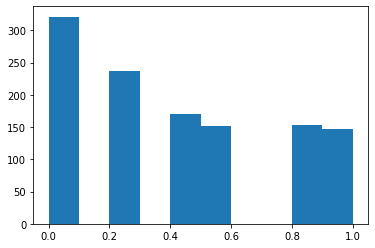

In [34]:
x = precision_data['Precision']
plt.hist(x)
plt.show()

In [ ]:
precision_data.describe()

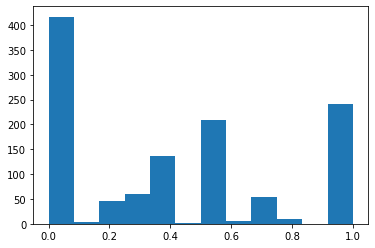

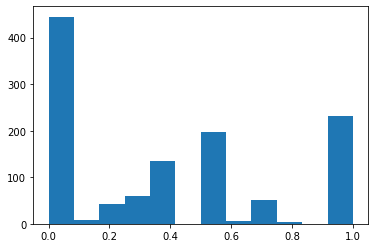

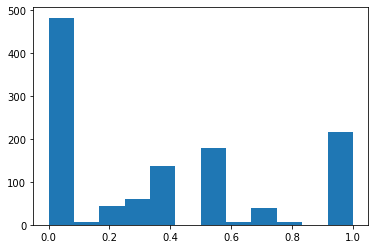

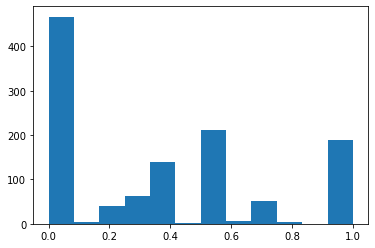

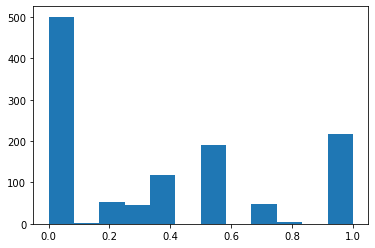

In [35]:
plt.hist(overlap_fsc_data[overlap_fsc_data['SimilarityRank'] == 0]['FSC_Overlap'],bins = 'sturges')
plt.show()
plt.hist(overlap_fsc_data[overlap_fsc_data['SimilarityRank'] == 1]['FSC_Overlap'],bins = 'sturges')
plt.show()
plt.hist(overlap_fsc_data[overlap_fsc_data['SimilarityRank'] == 2]['FSC_Overlap'],bins = 'sturges')
plt.show()
plt.hist(overlap_fsc_data[overlap_fsc_data['SimilarityRank'] == 3]['FSC_Overlap'],bins = 'sturges')
plt.show()
plt.hist(overlap_fsc_data[overlap_fsc_data['SimilarityRank'] == 4]['FSC_Overlap'],bins = 'sturges')
plt.show()


## Scenario 3
recomendações Titulo analise de resultados

In [37]:
# top most similiar to recommend
TOP_K = 5

# dataframe for precision
#data_precision = ["ID_Test", "RecommendationPrecision"]
#df_precision = pd.DataFrame([],columns=data_precision)



overlap_fsc_data, precision_data = evaluate_classes(False, TOP_K, 50000,'Titulo',model_titulo)



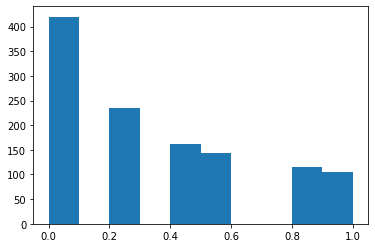

In [38]:
x = precision_data['Precision']
plt.hist(x)
plt.show()


In [ ]:
precision_data.describe()

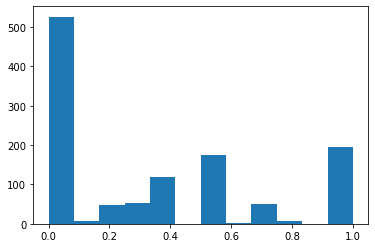

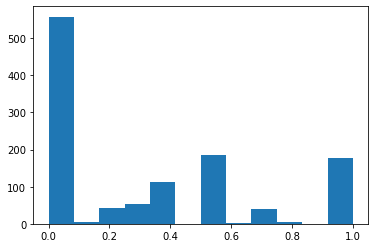

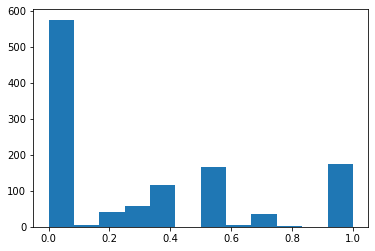

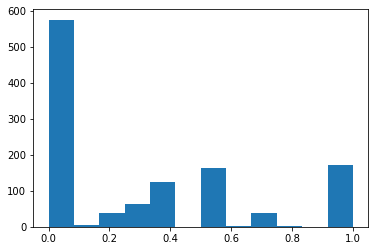

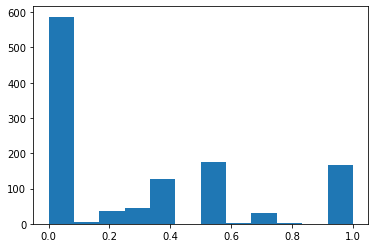

In [39]:
plt.hist(overlap_fsc_data[overlap_fsc_data['SimilarityRank'] == 0]['FSC_Overlap'],bins = 'sturges')
plt.show()
plt.hist(overlap_fsc_data[overlap_fsc_data['SimilarityRank'] == 1]['FSC_Overlap'],bins = 'sturges')
plt.show()
plt.hist(overlap_fsc_data[overlap_fsc_data['SimilarityRank'] == 2]['FSC_Overlap'],bins = 'sturges')
plt.show()
plt.hist(overlap_fsc_data[overlap_fsc_data['SimilarityRank'] == 3]['FSC_Overlap'],bins = 'sturges')
plt.show()
plt.hist(overlap_fsc_data[overlap_fsc_data['SimilarityRank'] == 4]['FSC_Overlap'],bins = 'sturges')
plt.show()


## Scenario 4
Junção das recomendações Titulo e Resumo

In [106]:
def evaluate_4(model_titulo,model_resumo,enableprint):
    ID_Test = []
    ID_Match = []
    SimilarityRank = []
    FSC_Overlap = []
    Precision = []
    ID_Precision_Test = []
    data = test_data.head(1000)
    for index,sample in data.iterrows():
        inferred_vector = model_titulo.infer_vector(gensim.utils.simple_preprocess(sample['Titulo']))
        sims2 = model_titulo.dv.most_similar([inferred_vector], topn=len(model_titulo.dv))

        inferred_vector2= model_resumo.infer_vector(gensim.utils.simple_preprocess(sample['Resumo']))
        sims = model_resumo.dv.most_similar([inferred_vector], topn=len(model_resumo.dv))
        numberFromTitle=math.floor(len(sims2)*0.2)
        numberFromAbstract=math.floor(len(sims)*0.8)
        finalResult =[]
        c=0
        for x in range(0,numberFromAbstract-1):
          finalResult.append(sims[x])
        c=numberFromTitle-1
        for y in range(0,numberFromTitle-1):
          finalResult.append(sims2[y])
        finalResult.sort(key=lambda x: x[1],reverse = True)
        l=[]
        for item in finalResult:
            if item[0] in l:
                finalResult.remove(item)
            else:
                l.append(item[0])
        
        relevant = 0
        for similarityRank in range(0,5):
            match_ID = train_data[train_data['ID'] == modelIndexToDataframeIndex[finalResult[0][0]-1]].iloc[0]['ID']

            best_match_fsc_row = get_FSC_classes_row(match_ID)
            test_fsc_row = get_FSC_classes_row(sample['ID'])

            fsc_list_best_match = validate_parse_fsc(best_match_fsc_row)
            fsc_test_data_row = validate_parse_fsc(test_fsc_row)

            intersection_fsc_classes = list(set(fsc_list_best_match).intersection(set(fsc_test_data_row)))

            if len(fsc_test_data_row) != 0:
                overlap_ratio = len(intersection_fsc_classes)/len(fsc_test_data_row)

                ID_Test.append(row['ID'])
                ID_Match.append(match_ID)
                SimilarityRank.append(similarityRank)
                FSC_Overlap.append(overlap_ratio)

                if intersection_fsc_classes and enableprint:

                    print("Test Sample ID : "+ row['ID'])
                    print("Match ID : " + match_ID)
                    print("Titulo Test Sample: "+ row['Titulo'])
                    #print("Titulo Match: "+ best_match_data.iloc[0]['Titulo'])

                    print("Resumo Test Sample: "+ row['Resumo'])
                    print("Resumo Match: "+ best_match_data.iloc[0]['Resumo'])
                    print("Class Overlap" + str(intersection_fsc_classes) )
                    print("Class Overlap Ratio" + str(overlap_ratio) + '\n')

                if overlap_ratio >= 0.5:
                    relevant += 1
        #print(relevant)
        precision = relevant / 5
        Precision.append(precision)
        ID_Precision_Test.append(row['ID'])
        #df_precision_new_row = {"ID_Test": ID_Test, "RecommendationPrecision":precision}
        #df_precision.append(df_precision_new_row, ignore_index=True)
        if enableprint:
            print("Precision" + str(precision) + '\n')


    return pd.DataFrame({"ID_Test":ID_Test,"ID_Match":ID_Match,"SimilarityRank":SimilarityRank,"FSC_Overlap":FSC_Overlap}), pd.DataFrame({"ID_Test":ID_Precision_Test,"Precision":Precision})


In [ ]:
   overlap_fsc_data, precision_data = evaluate_4(model_titulo,model_resumo,False)

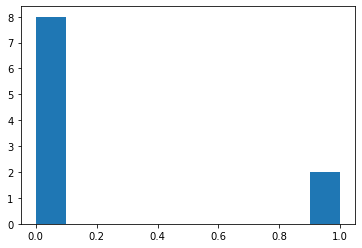

In [102]:
x = precision_data['Precision']
plt.hist(x)
plt.show()

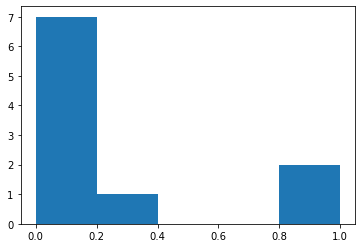

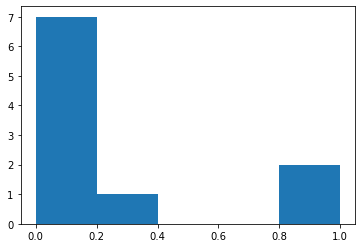

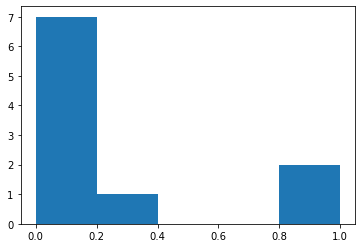

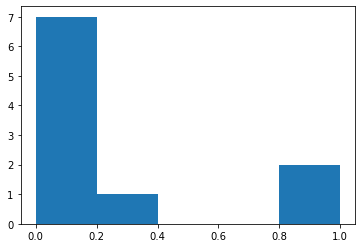

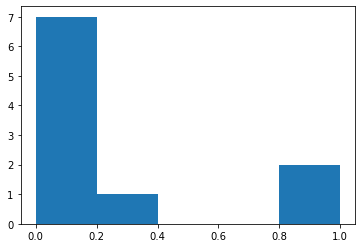

In [103]:
plt.hist(overlap_fsc_data[overlap_fsc_data['SimilarityRank'] == 0]['FSC_Overlap'],bins = 'sturges')
plt.show()
plt.hist(overlap_fsc_data[overlap_fsc_data['SimilarityRank'] == 1]['FSC_Overlap'],bins = 'sturges')
plt.show()
plt.hist(overlap_fsc_data[overlap_fsc_data['SimilarityRank'] == 2]['FSC_Overlap'],bins = 'sturges')
plt.show()
plt.hist(overlap_fsc_data[overlap_fsc_data['SimilarityRank'] == 3]['FSC_Overlap'],bins = 'sturges')
plt.show()
plt.hist(overlap_fsc_data[overlap_fsc_data['SimilarityRank'] == 4]['FSC_Overlap'],bins = 'sturges')
plt.show()